# Introduction

The Spotify Song Attributes Dataset contains data regarding several characteristics of music tracks available on Spotify in 2022. It contains 22 attributes and 10,080 rows, each identifying a unique music track. We will conduct an initial exploratory data analysis with the goal of generating visualizations for attributes of interest to assist us in further analyzing the relationships present in the data. The attributes can be described as follows:

The dataset used in this analysis can be downloaded at: <br>
https://www.kaggle.com/datasets/byomokeshsenapati/spotify-song-attributes

## Libraries and Configurations

In [1]:
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os
import warnings
os.environ['OMP_NUM_THREADS'] = '19'
alt.data_transformers.disable_max_rows() #disables max rows for altair

DataTransformerRegistry.enable('default')

## Data Cleaning
In this section, we will clean and reformat our dataset.

In [2]:
#dataset
spotify_data = pd.read_csv("C:/Users/patri/datasets/spotify songs/Spotify_Song_Attributes.csv")

#Select attributes of interest
selected_attributes = ['id', 'artistName', 'trackName', 'msPlayed', 'genre', 'danceability', 'energy', 'key', 
                   'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
                   'liveness', 'valence', 'tempo', 'type', 'time_signature']

spotify_f = spotify_data[selected_attributes] #Filtered dataset

missing_vals = spotify_f.isna().sum() #store missing values
print(missing_vals) #show missing values

#fill in missing values w/ 'Unknown' for genre
spotify_f['genre'].fillna('Unknown', inplace = True) 

spotify_f = spotify_f.loc[spotify_f['id'].notna()] #drop observations with a missing ID

spotify_f.isna().sum()

#checking for duplicates
duplicate_rows = spotify_f[spotify_f.duplicated()]
len(duplicate_rows)

spotify_f = spotify_f.drop_duplicates().reset_index(drop = True)
spotify_f.tail()

id                   550
artistName             0
trackName              0
msPlayed               0
genre               1500
danceability         550
energy               550
key                  550
loudness             550
mode                 550
speechiness          550
acousticness         550
instrumentalness     550
liveness             550
valence              550
tempo                550
type                 550
time_signature       550
dtype: int64


C:\Users\patri\AppData\Local\Temp\ipykernel_9212\1603919404.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify_f['genre'].fillna('Unknown', inplace = True)


id     artistName  \
4760  2qXicQG06oT0ijKBznpgQv           Ruel   
4761  6o8pM5reLgjd5i8gDY3Irt      Ben Zaidi   
4762  1EoThnDm6kQfB2idIfR30n    just valery   
4763  042Sl6Mn83JHyLEqdK7uI0  Billie Eilish   
4764  3BcN2Pcy0kTG1zm8Tz9MsB          Jaden   

                                trackName  msPlayed      genre  danceability  \
4760                              Younger   5272303      alt z         0.745   
4761                   Younger with Time.    668478   folk-pop         0.537   
4762  Your Love Is My Drug (8 Bit Slowed)     97600  sad lo-fi         0.282   
4763                           Your Power    988224    art pop         0.632   
4764              Your Voice / Bethel, NY    213626    pop rap         0.560   

      energy   key  loudness  mode  speechiness  acousticness  \
4760   0.477  11.0    -7.706   0.0       0.0880         0.202   
4761   0.143   2.0   -16.992   1.0       0.0331         0.961   
4762   0.158   6.0    -7.783   1.0       0.0311         0.438   
4763   0.284   9.0   -14.025   0.0       0.0801         0.932   
4764   0.344   3.0   -12.283   1.0       0.0306         0.866   

      instrumentalness  liveness  valence    tempo            type  \
4760          0.000000     0.120    0.454  136.055  audio_features   
4761          0.005720     0.110    0.245  131.118  audio_features   
4762          0.134000     0.474    0.248   65.152  audio_features   
4763          0.000476     0.233    0.208  129.642  audio_features   
4764          0.001470     0.111    0.428  115.393  audio_features   

      time_signature  
4760             4.0  
4761             3.0  
4762             4.0  
4763             4.0  
4764             3.0

I have reduced the dimensionality of the dataset and reordered the attributes to have the unique identifier as the first column. Following this, I checked the filtered dataset for missing values. It appears that observations with missing IDs were also missing entries for most of the other attributes. I've addressed the missing values by replacing null values in the 'genre' attribute with 'Unknown' and removing the observations with a missing ID as this was a relatively small portion of the overall dataset. Lastly, I have identified that the dataset has a duplicate of each observation, so I removed the duplicates.

In [3]:
data_types = [spotify_f.dtypes]
print(data_types) #Checking data types

#assign attributes data types
objects = ['id']
categories = ['artistName', 'trackName', 'genre', 'key', 'mode', 'type', 'time_signature']
integers = ['msPlayed']
floats = ['danceability', 'energy', 'loudness', 'speechiness',
         'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

spotify_f[objects] = spotify_f[objects].astype('object')
spotify_f[categories] = spotify_f[categories].astype('category')
spotify_f[integers] = spotify_f[integers].astype(int)
spotify_f[floats] = spotify_f[floats].astype('float64')

spotify_f.dtypes

#Reformat attributes

spotify_f['secondsPlayed'] = spotify_f['msPlayed']/1000 #appends new column w/ seconds played
spotify_f.sort_values(by = 'artistName', ascending = True, inplace = True) #sort artist name

columns_normalize = ['danceability', 'energy', 'loudness', 'speechiness', 
                        'acousticness', 'liveness', 'valence', 'tempo']

#Gaussian normalization
for column in columns_normalize:
    spotify_f[column] = (spotify_f[column] - spotify_f[column].mean()) / (spotify_f[column].std())

spotify_f.head()

[id                   object
artistName           object
trackName            object
msPlayed              int64
genre                object
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
time_signature      float64
dtype: object]


id   artistName  \
1616  39OqZkxrUiMAR1bG3oquBA          !!!   
4204  3M1RZOhzt4lG3vpSYwffhe          !!!   
1848  0j8ppsOOawdPCJnSTcXgOy         $NOT   
1841  0jZrlNfW35trATveaKIjGA        $ober   
7     30QR0ndUdiiMQMA9g1PGCm  $uicideboy$   

                                              trackName  msPlayed  \
1616                         Even When The Water's Cold    227066   
4204                                         The Hammer      3130   
1848                                              GOSHA    360000   
1841                                        GLOCK GLOCK     49386   
7     ...And to Those I Love, Thanks for Sticking Ar...    120005   

                  genre  danceability    energy   key  loudness mode  \
1616  alternative dance      0.681643  1.098189   2.0  0.339436  0.0   
4204  metallic hardcore     -1.923694  1.402014   6.0  0.932038  1.0   
1848      aesthetic rap      1.550089 -0.474313   0.0 -0.268679  1.0   
1841            Unknown      0.060419  1.303476  11.0  1.428428  0.0   
7             cloud rap      1.201443 -0.215651   2.0  0.334080  1.0   

      speechiness  acousticness  instrumentalness  liveness   valence  \
1616    -0.490202     -0.765425          0.001310 -0.119223  1.783087   
4204     0.967882     -1.084631          0.000000  1.540360  0.749205   
1848     4.213616      1.337132          0.000013  1.150320  0.221965   
1841    -0.327915     -0.968802          0.000029  0.576731  0.951038   
7       -0.468980     -0.714581          0.000090 -0.264532 -1.330918   

         tempo            type time_signature  secondsPlayed  
1616 -0.496729  audio_features            4.0        227.066  
4204  1.517300  audio_features            4.0          3.130  
1848 -1.358855  audio_features            4.0        360.000  
1841  1.398451  audio_features            4.0         49.386  
7    -0.185947  audio_features            4.0        120.005

Here I have created a new column 'secondsPlayed' by converting 'msPlayed' to seconds and I sorted the dataset by artist name in alphabetical order. I have also applied Gaussian normalization to all of the float attributes aside from 'instrumentalness' (because 'instrumentalness' is a probability, thus its interpretation is not as ambiguous and its range is not likely to introduce bias into models we may choose to fit on this data). <br> <br> 
This serves two purposes: <br>
i) Machine learning algorithms, such as linear regression, SVM, and k-means clustering are sensitive to the scales of their input features. Reducing the scale mitigates this issue should we choose to employ any of these techniques. <br> <br>
ii) We can more systematically, uniformly and efficiently discern the presence of outliers in the data when the attributes are normalized in this manner. Setting cutoffs above and below standard deviations is not only more intuitive, but also allows us to avoid analyzing each attribute to determine multiple cutoff points for outliers.

## Descriptive Statistics and Visualization

In this section, we will get a better handle on the distributions of attributes in our dataset by using interactive visualizations and descriptive statistics.

I am interested in exploring the distributions of and relationships between the 'loudness', 'tempo', 'danceability', 'energy' and 'valence' attributes. See below for some plots to help visually assess the distributions and correlations of these attributes.

In [4]:
def plot_histogram(dataframe, attribute_name, title):
    '''
    Function that makes it convenient to plot several histograms.
    dataframe = pandas dataframe object
    attribute_name = string identifying the attribute you would like to plot on the x-axis
    title = string that will title the x-axis and part of the chart title
    '''
    histogram = alt.Chart(dataframe).mark_bar().encode(
        alt.X(f'{attribute_name}:Q', bin = alt.Bin(maxbins = 50), title = title), y = 'count()'
    ).properties(
        title = f'Histogram of {title}',
        width = 250,
        height = 250
    )
    return histogram

#histograms
loudness_histogram = plot_histogram(spotify_f, 'loudness', 'Loudness')
tempo_histogram = plot_histogram(spotify_f, 'tempo', 'Tempo')
danceability_histogram = plot_histogram(spotify_f, 'danceability', 'Danceability')
valence_histogram = plot_histogram(spotify_f, 'valence', 'Valence')
energy_histogram = plot_histogram(spotify_f, 'energy', 'Energy')

#plots
piped_plots = loudness_histogram | tempo_histogram | danceability_histogram | valence_histogram | energy_histogram
piped_plots

alt.HConcatChart(...)

These attributes have all been standardized to $N ~ (0,1)$ since we applied Gaussian normalization to each of them, however, we note that the realizations of these attributes are very different. Energy and valence appear to have far less, if any, outliers compared to loudness, tempo and danceability. There are definitely some outliers to consider prior to any statistical analysis for loudness, tempo and danceability. Particularly loudness.

In [5]:
#Plot 1 - scatterplot

#create dropdowns and options for x, y axes
dropdown_x = alt.binding_select(options = columns_normalize, name = "X-axis Attribute:")
dropdown_y = alt.binding_select(options = columns_normalize, name = "Y-axis Attribute:")
dropdown_genre = alt.binding_select(options = spotify_f['genre'].value_counts().index.to_list(), 
                                    name = "Highlight Genre:")

#parameters to add to the plot
selection_x = alt.param(value = ['loudness'], bind = dropdown_x)
selection_y = alt.param(value = ['energy'], bind = dropdown_y)

#defines the selection for genres, defaults to all genres being equally salient
selection_genre = alt.selection_point(value = None, fields = ['genre'], bind = dropdown_genre)

#dynamic scatterplot
s_plot = alt.Chart(spotify_f).mark_point().encode(
    x=alt.X('x_attribute:Q', title = 'X-Attribute'),
    y=alt.Y('y_attribute:Q', title = 'Y-Attribute'),
    color = alt.condition(selection_genre, alt.Color('genre:N').legend(None), alt.value('lightgray')), #color is set by genre
    opacity = alt.condition(selection_genre, alt.value(1), alt.value(0.07)), #opacity is set by the dropdown selection
    tooltip = ['artistName', 'trackName'] #tooltip will show artist and track name
).properties(
    width=500,
    height=500
).transform_calculate(
    x_attribute = f'datum[{selection_x.name}]',
    y_attribute = f'datum[{selection_y.name}]',
    plot_filter = f'datum[{selection_genre.name}]'
).add_params(
    selection_x, selection_y,
    selection_genre
).interactive( #allows you to zoom and pan on the plot
).properties(
    title = 'Plot of selected X and Y attributes'
)


# Plot 2 - heatmap

#calculating correlation matrix
corr_data = spotify_f[columns_normalize] 
correlation_matrix = corr_data.corr().round(decimals = 2) #calculate the correlation matrix
correlation_long = correlation_matrix.unstack().reset_index() #convert correlation matrix into long-form dataframe
correlation_long.columns = ['Attribute1', 'Attribute2', 'Correlation']


#plotting correlation heatmap

#base chart holdling data to add marks to

base = alt.Chart(correlation_long).encode(
    x = alt.X('Attribute1:O', title = None),
    y = alt.Y('Attribute2:O', title = None))

#adds the heatmap to the base chart
corr_heatmap = base.mark_rect().encode(
    color = alt.Color('Correlation:Q', scale = alt.Scale(domain = [-1,1], scheme = 'redblue'),
                       legend = alt.Legend(title = 'Correlation'))
).properties(
    title = "Correlation Heatmap",
    width = 500,
    height = 500
)

#add text of corresponding correlation coefficient to each square
coeff_text = base.mark_text(baseline = 'middle', fontSize = 12).encode(
    text = "Correlation:Q",
    color = alt.condition(
        alt.datum.Correlation == 1,
        alt.value('white'),
        alt.value('black'))
)

full_heatmap = corr_heatmap + coeff_text
heatmap_scatter = full_heatmap & s_plot
heatmap_scatter.save('heatmap_scatter.html')
heatmap_scatter

alt.VConcatChart(...)

The plots above work together to aid in the selection of informative scatterplots for each of the attributes plotted against one another. Additionally, the data can be filtered by genre in the scatterplot. 

This helps to efficiently assess where correlations are present in the data, and if those relationships hold across genres. For example, the default values have been set to plot a track's loudness vs. a track's energy. We can see a strong positive correlation between loudness and energy in the correlation heatmap and we can see that the correlation appears to hold across genres in the scatterplot as we filter through genres.

## Machine Learning

Now that the data has been cleaned and we have a general handle of the relationships between the attributes we are interested in we can begin to analyze the data. I am going to implement k-means clustering to group the tracks based on their features. K will be set using the elbow method.

I hope to glean some information that will help identify tracks (and artists) similar to one another. I have chosen not to group the tracks by artist and use means for the attributes as many artists produce tracks that are wildly different from one another, particularly 'hit' tracks which may differ from the rest of their discography.

Consequently, many artists may be well-known for one or two tracks that are not representative of the rest of their work. If this were to be used in a recommendation algorithm, I would like it to recommend other artists based on each track's features, not average features of a track's artist.

<function matplotlib.pyplot.show(close=None, block=None)>

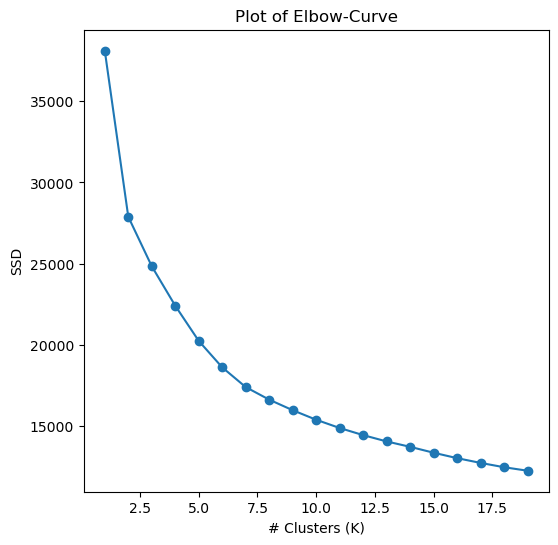

In [6]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
#scale our data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(spotify_f[columns_normalize])

#Setting K using the elbow method
ssd = []
k_poss = range(1,20) #range of possible K's

for k in k_poss:
    kmeans = KMeans(n_clusters = k, n_init = 10)
    kmeans.fit(scaled_data)
    ssd.append(kmeans.inertia_)
    
#Elbow-curve plot
plt.figure(figsize = (6,6))
plt.plot(k_poss, ssd, marker = 'o')
plt.xlabel('# Clusters (K)')
plt.ylabel('SSD')
plt.title('Plot of Elbow-Curve')
plt.show

From the plot above, we can see that our 'elbow' would reasonably lie at $K = 3$ or $K = 4$. However, since the slope of the elbow curve is very steep for $K \leq 3$ I belive the tradeoff for significantly lower inertia is worth it so I will set $K = 4$.

In [141]:
from sklearn.metrics import silhouette_score
#K-means clustering
k_means_model = KMeans(n_clusters = 4, n_init = 10, random_state = 55)
spotify_f['cluster'] = k_means_model.fit_predict(scaled_data)

#Checking size of each cluster
k_counts = spotify_f['cluster'].value_counts().reset_index()
k_counts.columns = ['Cluster', 'Count']

#Bar chart of cluster counts
k_counts_plot = alt.Chart(k_counts).mark_bar().encode(
    x = alt.X('Cluster:O'),
    y = alt.Y('Count:Q'),
    color = 'Cluster:N'
).properties(
    title = 'Number of Tracks in each Cluster',
    width = 300,
    height = 300
)

#calculate silhouette score
sil_coeff = silhouette_score(scaled_data, spotify_f['cluster'])
print(f'The silhouette score is : {sil_coeff}')

k_counts_plot

The silhouette score is : 0.3002957118257905


alt.Chart(...)

Now we can examine the mean attribute values of the features in each cluster to gain a better understanding of the types of songs that are in the clusters.

In [8]:
#Group the data by cluster and calculate feature means
feature_means = spotify_f.groupby('cluster').mean()[columns_normalize]
feature_means.reset_index(inplace = True)
feature_means

#Convert data into long format
feature_means_long = feature_means.melt(id_vars = 'cluster', var_name = 'feature', value_name = 'mean')

feature_chart = alt.Chart(feature_means_long).mark_bar().encode(
    x='cluster:N',
    y='mean:Q',
    color='cluster:N',
    facet='feature:N'
).properties(
    title='Feature Means by Cluster',
    width=200,
    height=200
)

feature_chart

alt.Chart(...)

## Insights

From the plots above we can see the following trends for each cluster: <br> <br>
i) Cluster 0 contains songs with the highest average danceability, energy, loudness and valence. <br> <br>
ii) Cluster 1 contains songs with slightly lower average danceability, energy and loudness compared to cluster 0. The differentiator here appears to be speechiness--cluster 0 and cluster 1 likely have similar genre composition, but cluster 0 contains more instrumental songs compared to cluster 1. <br> <br>
iii) Cluster 2 contains songs with the highest average acousticness and lowest average danceability, energy, loudness and valence. These are likely mellow or sad songs compared to the other clusters. <br> <br>
iv) Cluster 3 contains songs that have similar features to cluster 2, but the differentiators here appear to be energy and loudness. Considering that these two were shown to be highly correlated in an earlier section, it may be worth considering re-running this analysis, dropping one of energy or loudness and comparing the results.
<br> <br>
The clustering model produced a silhouette score of 0.30. This suggests that our clusters are neither densely packed, nor very spread out. I would like to see if we can improve this.
<br> <br>
This gives us some good insights into how the features might differentiate each cluster of songs, but we did not take into account song genres and we noticed that we had some highly correlated features. We should see if we can improve the clusters (decreasing inter-cluster similarity and increasing intra-cluster similarity) by including genres and recoding some of our correlated features.

## Feature Engineering and Model Improvement

In this section, we will attempt to improve our clustering model by engineering new features and incorporating the 'genre' attribute via one hot encoding. Once satisfied, we will attempt to interpret the features by which clusters differ and assign labels to each cluster.

Keeping the goal of the clusters in mind (we want to use them as the basis for a recommender system) we can create some features that will help distill the essence of each song further.

In [9]:
from sklearn.preprocessing import OneHotEncoder

#Combining valence and energy into a new feature 'mood'
spotify_f['mood'] = spotify_f['valence'] * spotify_f['energy']

#Combining tempo and danceability into a new feature 'rhythm'
spotify_f['rhythm'] = spotify_f['tempo'] * spotify_f['danceability']

'''
Use onehot-encoding to add top 10 genres as features, assign all other genres to 'Other'.
Since 'Unknown' is the most frequent genre, we'll encode it as 'Other' as well.
'''

#get top 10 genres and replace other genres with 'Other'
top_10_genres = spotify_f['genre'].value_counts().index[1:11].tolist()
spotify_f['genre'] = spotify_f['genre'].apply(lambda x: x if x in top_10_genres else 'Other')

#one-hot encode the genres
def onehot_encode(df, column):
    """
    Idempotently one-hot encodes a column in a dataframe.
    
    Parameters:
    - df: The dataframe.
    - column: The column to one-hot encode.
    
    Returns:
    - The dataframe with the column one-hot encoded.
    """
    #check if the column exists in the dataframe
    if column not in df.columns:
        return df
    
    #check if the column has already been one-hot encoded by checking for the presence of expected encoded columns
    encoder = OneHotEncoder(sparse=False)
    encoded = encoder.fit_transform(df[[column]])
    encoded_columns = encoder.get_feature_names_out([column])
    
    if set(encoded_columns).issubset(df.columns):
        return df
    
    #perform one-hot encoding
    encoded_df = pd.DataFrame(encoded, columns = encoded_columns).reset_index(drop = True)
    df = pd.concat([df.reset_index(drop = True), encoded_df], axis = 1)
    
    #drop the original column
    df = df.drop(columns = column)
    
    return df

spotify_f = onehot_encode(spotify_f, 'genre')
spotify_new_features = spotify_f

print(spotify_new_features['mood'].describe())
print(spotify_new_features['rhythm'].describe())
print(spotify_new_features.columns)

count    4765.000000
mean        0.448453
std         0.985256
min        -2.775555
25%        -0.094407
50%         0.192997
75%         0.898463
max         3.913854
Name: mood, dtype: float64
count    4765.000000
mean        0.009499
std         1.187893
min        -8.239700
25%        -0.379486
50%        -0.000174
75%         0.324163
max        15.723557
Name: rhythm, dtype: float64
Index(['id', 'artistName', 'trackName', 'msPlayed', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'type',
       'time_signature', 'secondsPlayed', 'cluster', 'mood', 'rhythm',
       'genre_Other', 'genre_alt z', 'genre_alternative metal',
       'genre_anime lo-fi', 'genre_art pop', 'genre_brostep',
       'genre_dance pop', 'genre_drift phonk', 'genre_filmi', 'genre_pop',
       'genre_singer-songwriter pop'],
      dtype='object')


In [26]:
'''
drop the old features since the new features were constructed using them and they will be highly
correlated and redundant
'''
spotify_new_features = spotify_f.drop(columns = ['valence', 'energy','tempo','danceability'])

#normalize the numerical features
numerical_features = ['loudness', 'speechiness','acousticness','liveness','mood', 'rhythm', 
                      'instrumentalness']
features_for_clustering = numerical_features + [col for col in spotify_f.columns if 'genre_' in col]

scaled_data = scaler.fit_transform(spotify_new_features[features_for_clustering])
scaled_data.shape

(4765, 18)

<function matplotlib.pyplot.show(close=None, block=None)>

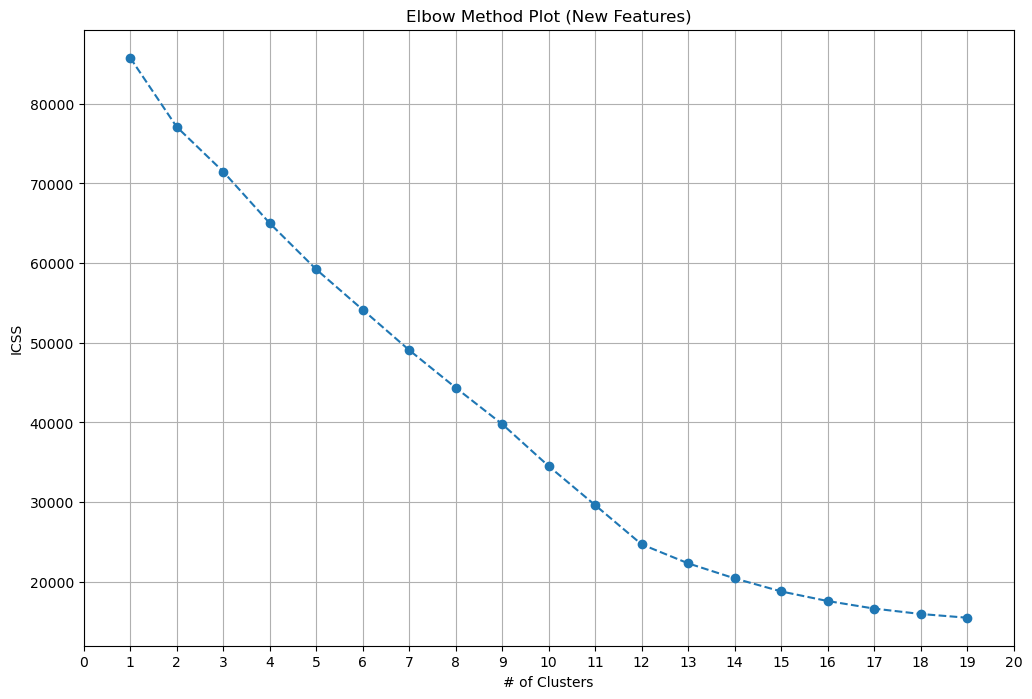

In [29]:
#elbow method to determine optimal number of clusters
wcss = []

for i in range(1,20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 55)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)
    
#elbow graph #2
plt.figure(figsize = (12,8))
plt.plot(range(1,20), icss, marker = 'o', linestyle = '--')
plt.title('Elbow Method Plot (New Features)')
plt.xlabel('# of Clusters')
plt.xticks(range(0,21))
plt.ylabel('ICSS')
plt.grid(True)
plt.show

From the plot above, we can see that we are able to consistently reduce inter-cluster similarity up to about $K = 12$ clusters.

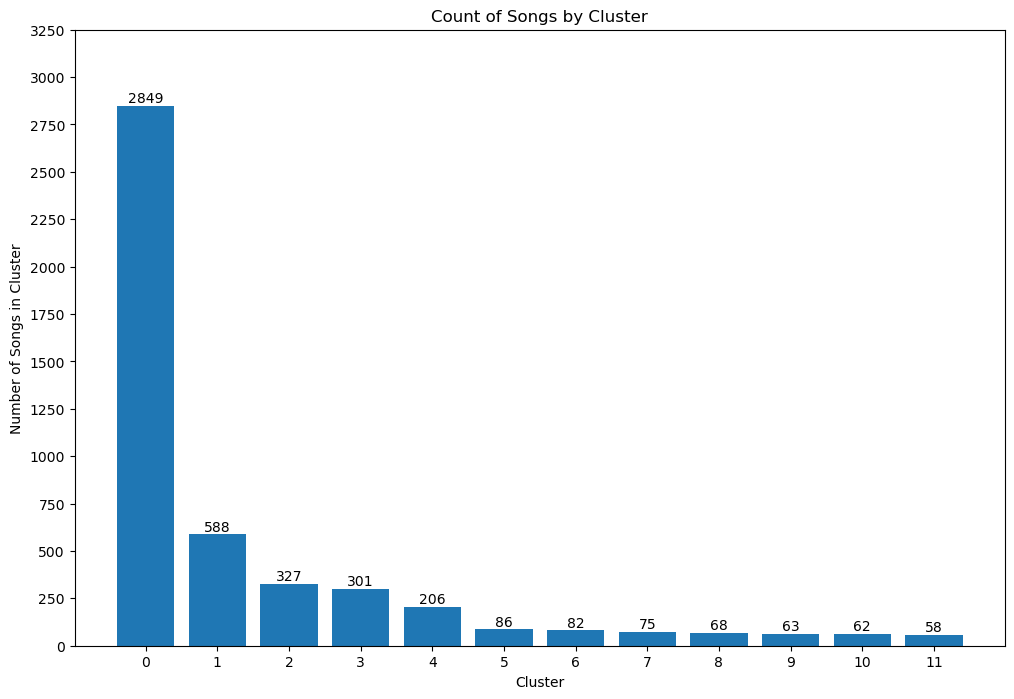

In [63]:
from sklearn.decomposition import PCA

#apply k-means clustering
kmeans = KMeans(n_clusters = 12, random_state = 55)
spotify_new_features['cluster'] = kmeans.fit_predict(scaled_data)
cluster_counts = spotify_new_features['cluster'].value_counts()

plt.figure(figsize = (12,8))
plot = plt.bar(range(0,12), cluster_counts)
plt.xlabel('Cluster')
plt.xticks(range(0,12))
plt.yticks(range(0,3500,250))
plt.ylabel('Number of Songs in Cluster')
plt.title('Count of Songs by Cluster')
for bar in plot:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, str(height), ha = 'center', va = 'bottom')
plt.show()

In [136]:
feature_means = spotify_new_features.groupby('cluster').mean()[numerical_features]
feature_means

loudness  speechiness  acousticness  liveness      mood    rhythm  \
cluster                                                                      
0       -1.775285    -0.330006      1.372767 -0.308365  1.656999  0.655163   
1        0.225289    -0.147018      0.018784  0.069363  0.583906  0.026792   
2        0.282476     0.053466     -0.250158  0.065126  0.233569 -0.099945   
3        0.074329     0.058683      0.294546 -0.056932  0.257888 -0.047858   
4       -2.541869    -0.224595      1.573742 -0.200291  0.781942 -0.175242   
5        0.750867    -0.022691     -0.782197 -0.055159  0.676380 -0.019161   
6        0.899508     0.545054     -0.928754  0.602351 -0.179880 -0.286601   
7        0.787859     0.603462     -0.759373  0.329471  0.299916  0.215809   
8        0.471183    -0.007386     -0.747758  0.645521  0.200228  0.031946   
9        0.121553     0.065440     -0.039804 -0.237765  0.349221 -0.183768   
10       0.051933    -0.389362     -0.014622 -0.325825  0.613220  0.127439   
11       0.422109     0.068872     -0.243194 -0.150455  0.301399 -0.078556   

         instrumentalness  
cluster                    
0                0.696517  
1                0.011993  
2                0.071913  
3                0.005694  
4                0.906191  
5                0.001920  
6                0.052833  
7                0.522359  
8                0.070660  
9                0.007308  
10               0.096133  
11               0.007022

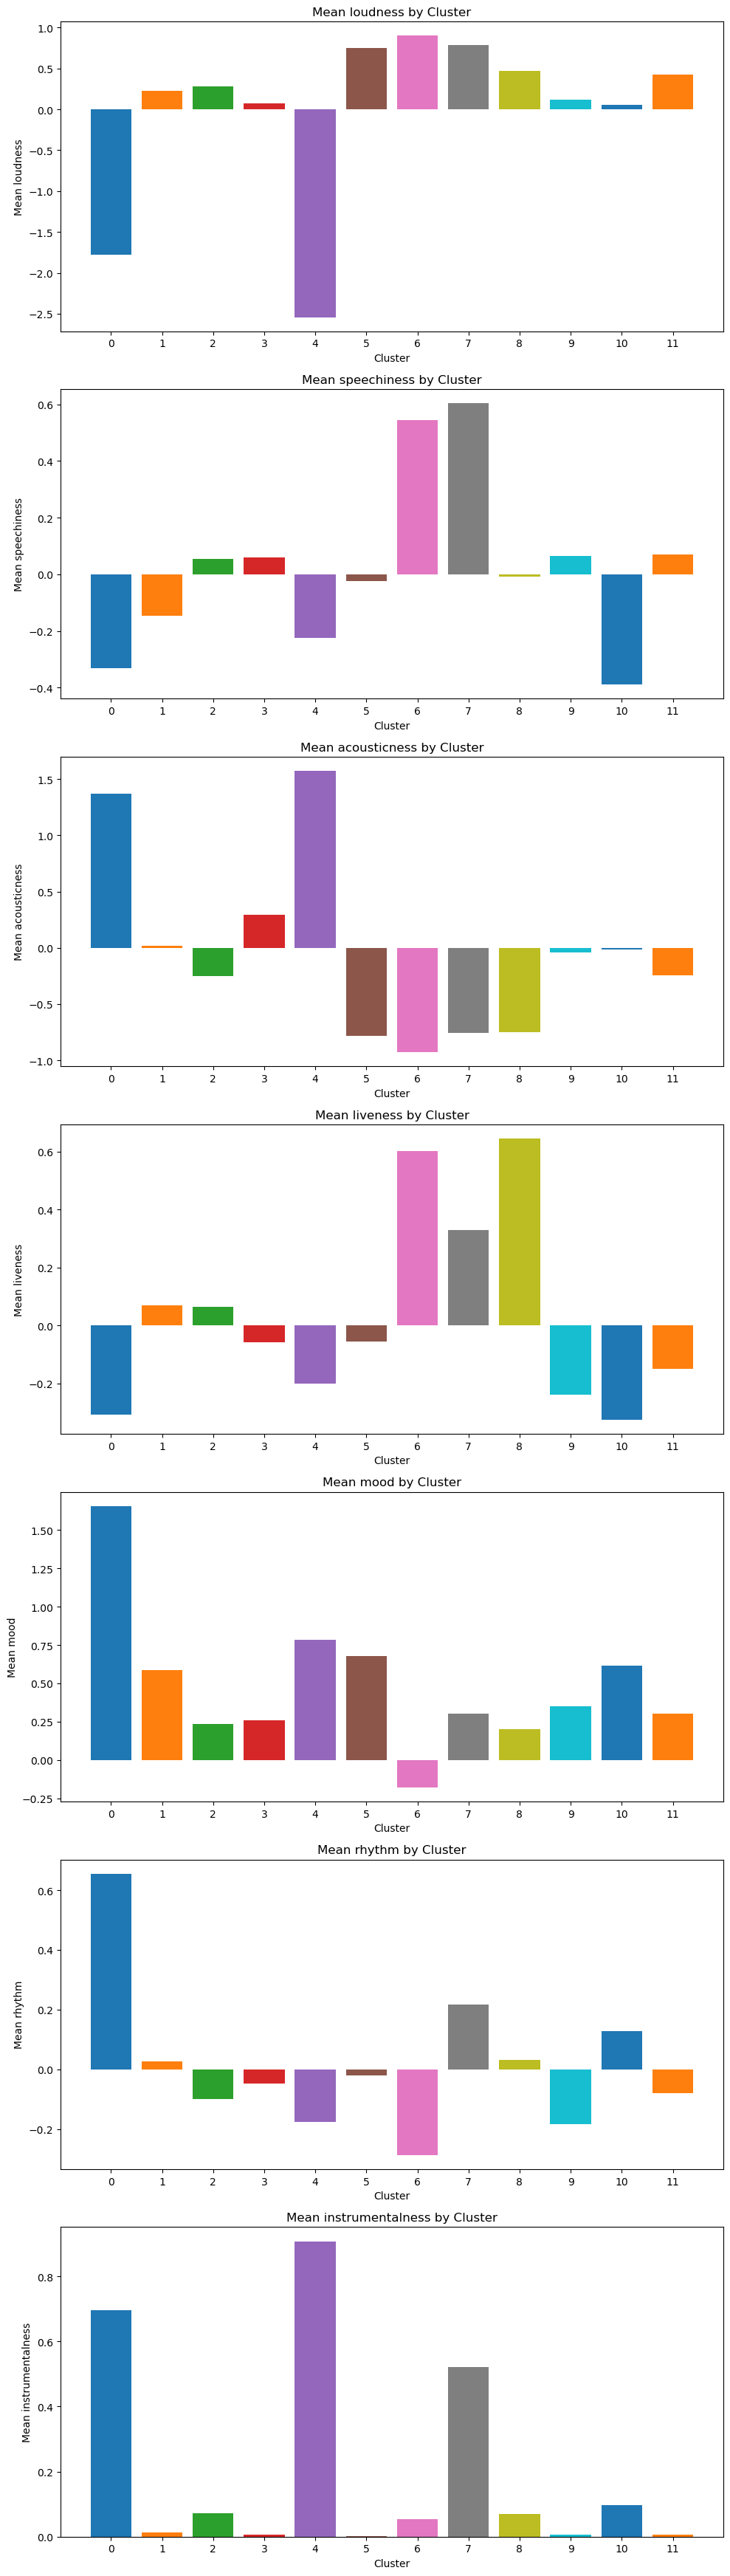

In [135]:
feature_means = spotify_new_features.groupby('cluster').mean()[numerical_features]

n_features = len(numerical_features)
fig, axes = plt.subplots(nrows=n_features, figsize=(10, 5*n_features))
cmap = plt.get_cmap('tab10')
colors = cmap(np.arange(len(feature_means.index.unique())) % cmap.N)

for ax, feature in zip(axes, feature_means):
    ax.bar(feature_means.index, feature_means[feature], color=colors)
    ax.set_xlabel('Cluster')
    ax.set_ylabel(f'Mean {feature}')
    ax.set_title(f'Mean {feature} by Cluster')
    ax.set_xticks(range(0, max(spotify_new_features['cluster']) + 1))

plt.tight_layout()
plt.show()


In [101]:
genres = [col for col in spotify_new_features.columns if 'genre_' in col]
genre_counts = spotify_new_features.groupby('cluster').sum()[genres]
print(genre_counts)

         genre_Other  genre_alt z  genre_alternative metal  genre_anime lo-fi  \
cluster                                                                         
0              587.0          1.0                      0.0                0.0   
1                0.0          0.0                      0.0                0.0   
2             2849.0          0.0                      0.0                0.0   
3                0.0        327.0                      0.0                0.0   
4                0.0          0.0                      0.0               68.0   
5                0.0          0.0                      0.0                0.0   
6                0.0          0.0                      0.0                0.0   
7                0.0          0.0                      0.0                0.0   
8                0.0          0.0                     75.0                0.0   
9                0.0          0.0                      0.0                0.0   
10               0.0        

In [142]:
sil_coeff = silhouette_score(scaled_data, spotify_new_features['cluster'])
print(f'The silhouette score is : {sil_coeff}')

The silhouette score is : 0.45048255805644133


## Conclusions
In this analysis, I began by conducting an exploratory data analysis into the Spotify Song Attributes dataset. After cleaning and reformatting the data I selected 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence', and 'tempo' as our attributes of interest. I then normalized the attributes and explored our attributes of interest using several visualizations to help identify and establish relationships between them.

I began with an initial implementation of a K-means clustering algorithm, yielding a silhouette score of 0.30, to group the songs into clusters based on their features and visualized them via a faceted bar chart. However, I noted some issues with this first pass and improved upon the model by recoding some of our correlated features and incorporating genres into a second clustering analysis.

After recoding the correlated features and incorporating the top 10 genres as features, the silhouette score improved to 0.45 which indicates a fairly well-defined clustering structure.

Overall, I have discerned some useful relationships in the dataset, and I will be using the results as the framework for a recommendation algorithm.

# Appendix - Improvements

Some improvements that could be made to this analysis include:

i) Handling Outliers: We noted some outliers may have been present in our data, specifically in the 'loudness' and 'tempo' attributes. I determined that they were not impactful enough to warrant removing/adjusting for this analysis, but they could be dealt with in a more systematic manner.

ii) Recommendation System: The clusters could be used as pre-filters in a music recommendation algorithm. E.g. if a user had a profile where they indicated that they liked songs from a few clusters, songs from those clusters could be recommended to them more frequently.